# Recurrent Neural Network in TensorFlow 2.0
## Univariate, *many-to-one* forecast

Author: **Ivan Bongiorni**, Data Scientist.
[LinkedIn profile](https://www.linkedin.com/in/ivan-bongiorni-b8a583164/).

**Recurrent Neural Networks** are the time series version of Artificial Neural Networks. I will skip the theory behing the recurrent cells available in the Deep Learning literature (basic RNN cells, LSTMs, GRUs) and will show how to implement a basic one in **TensorFlow 2.0**. Since LSTM cells are by far the most common, and arguably the most performing RNN cells, I will employ those.

This time, I will show a ***many-to-one*** RNN implementation. In other words, I will train an RNN that takes a sequence of data as input, and returns a prediction of the single, following variables state.

Moreover, I will show **how to prepare RNN input**. This is a crucial point for all TensorFlow 2.0 / Keras users, since it can be quite confusing at the beginning (it certainly was for me).

And of course, I will show how to train an RNN in **Eager execution**, avoiding Keras' syntax. Higher freedom in implementation always comes at the price of slightly higher complexity.

### Bitcoin price prediction
For this task, I will employ **Bitcoin** (**BTC**) price time series. The goal of the present Notebook is to implement an RNN that is able to predict daily BTC closing price, provided a sequence of previous states.

Summary:
0. Import data
0. Dataprep for RNNs
0. RNN architecture
0. Training
0. Prediction

In [1]:
import numpy as np
import pandas as pd
from sklearn.utils import shuffle

import tensorflow as tf
print(tf.__version__)

from matplotlib import pyplot as plt

2.0.0-beta0


# 0. Import data

I can read the BTC data table directly from [coinmarketcap](https://coinmarketcap.com/currencies/bitcoin/historical-data/?start=20130428&end=20190626). It reports daily prices, together with volume and market capitalization in US dollars.

Pandas has a `.read_html()` function to take data directly from websites. The link returns two dataframes; daily BTC price data are in the first, therefore I'll keep only that.

In [2]:
df, _ = pd.read_html('https://coinmarketcap.com/currencies/bitcoin/historical-data/?start=20130428&end=20190626')

print(df.shape)

(2251, 7)


In [3]:
# I don't like colnames, so I'll rename them
df.columns = ['date', 'open', 'high', 'low', 'close', 'volume', 'marketcap']

In [4]:
# Sort data from older to newer
df.sort_index(ascending = False, inplace = True)
df.reset_index(inplace = True)
df.head(10)

,index,date,open,high,low,close,volume,marketcap
0,2250,"Apr 28, 2013",135.30,135.98,132.10,134.21,-,1488566728
1,2249,"Apr 29, 2013",134.44,147.49,134.00,144.54,-,1603768865
2,2248,"Apr 30, 2013",144.00,146.93,134.05,139.00,-,1542813125
3,2247,"May 01, 2013",139.00,139.89,107.72,116.99,-,1298954594
4,2246,"May 02, 2013",116.38,125.60,92.28,105.21,-,1168517495
5,2245,"May 03, 2013",106.25,108.13,79.10,97.75,-,1085995169
6,2244,"May 04, 2013",98.10,115.00,92.50,112.50,-,1250316563
7,2243,"May 05, 2013",112.90,118.80,107.14,115.91,-,1288693176
8,2242,"May 06, 2013",115.98,124.66,106.64,112.30,-,1249023060
9,2241,"May 07, 2013",112.25,113.44,97.70,111.50,-,1240593600


I chose each day's BTC closing price for my analysis. Since it's a univariate exercise I'll take just that one:

In [5]:
# take BTC closing price series
price = df.close.values

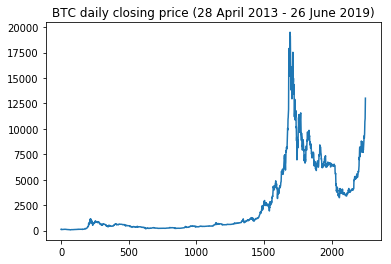

In [6]:
plt.plot(price)
plt.title('BTC daily closing price (28 April 2013 - 26 June 2019)')
plt.show()

# 1. Dataprep for RNNs

The first thing to do is to scale your time series in the `[0, 1]` interval. Canonical LSTM cells contain **Sigmoid** and **Tanh** gates that do their best when data are in that range.

## Train-Test split
The current analysis is univariate, this means that we are trying to predict future values of a given series exclusively on the basis of its previous states. Because of this, a train-test split must be temporal, i.e. all the observations before a given point in time will be used to train the model, and all the observations after that will be used to test its performance.

In [7]:
test_size = 500

Train = price[:-test_size]
Test = price[-test_size:]

print(len(Train))
print(len(Test))

1751
500


In [8]:
# save max() and min() to revert scaling later
max_price = np.max(Train)
min_price = np.min(Train)

# Min-max scaling based on Train params:
Train = (Train - min_price) / (max_price - min_price)
Test = (Test - min_price) / (max_price - min_price)

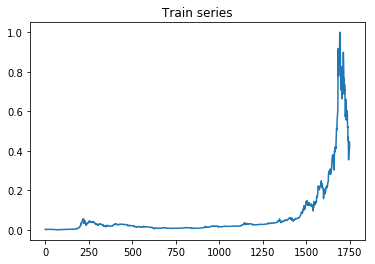

In [9]:
plt.plot(Train)
plt.title('Train series')
plt.show()

## Choosing a window size

A very important hyperparameter is the size of the time window that you are going to feed into the Network at each iteration. Dataprep for RNNs requires series data to be preprocessed in sliding sequences. Given the series:

```
A, B, C, D, E, F, G, H, I
```

Assuming you want to use the previous 3 states to predict the following one, you would get:

```
 Train:        Test:
 A, B, C       D
 B, C, D       E
 C, D, E       F
 D, E, F       G
 E, F, G       H
 F, G, H       I
```

The observations RNNs receive as inputs are series of data. Each series covers a time window of the series. Their length is an hyperparameter of the model that one can choose, and that I determined by an input of 90 days. The output sequence will be 1 day instead.

In [10]:
window_size = 90

The observations RNNs receive as inputs are series of data. Each series covers a time window of the series. Their length is an hyperparameter of the model that one can choose, and that I determined by `window_size` = 90 days.

In [11]:
# Dataprep function for RNN data

def RNN_dataprep(series, window):
    '''
    Given a time series and a time window hyperparameter, 
    returns Train and Test numpy arrays for RNNs
    '''
    import numpy as np
    
    # create train dataframe
    train = np.empty((len(series)-window, window))
    
    # take each row/time window
    for i in range(train.shape[0]):
        train[i,:] = series[i : i+window]
    
    # take each t+1 as test
    test = series[window:]
    
    # set common data type
    train = train.astype(np.float32)
    test = test.astype(np.float32)
    
    # reshape data as required by Keras LSTM
    train = train.reshape((len(train), window, 1))
    test = test.reshape((len(test), 1))
    
    return train, test


In [12]:
# Get all Train and Test data
X_train, Y_train = RNN_dataprep(Train, window_size)
X_test, Y_test = RNN_dataprep(Test, window_size)

## Understand the shape of input data for RNNs

This is a crucial point. It was not at all clear to understand how to reshape the input data for RNNs, and it's important to spend few words on it.

Let's take a look at the shape of input data for Keras' LSTM layers:

In [13]:
print(X_train.shape)
print(X_test.shape)

(1661, 90, 1)
(410, 90, 1)


Input data must follow this pattern:

`( Number of observations ,  Window size  ,  Number of input series )`

The *Number of observations* is straightforward. *Window size* is the hyperparameter that I chose above. The *Number of input series* is just 1, sice this is a univariate exercise.

Target data, on the other side, don't require much explanation:

In [14]:
print(Y_train.shape)
print(Y_test.shape)

(1661, 1)
(410, 1)


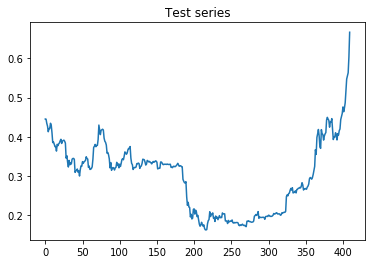

In [15]:
plt.plot(Y_test)
plt.title('Test series')
plt.show()

# 2. RNN architecture

The initial LSTM layer requires a specification of its `input_shape`. To correctly specify this, follow this simple rule: take the `X_train.shape`: `(1661, 90, 1)`, drop the first dimension: `(90, 1)`, there you have the correct `input_shape`. It's as easy as that.

For Deep RNNs, each `LSTM()` that is not the last requires `return_sequences = True`. That is because an LSTM layer that is not outputting to a `Dense(1)` layer must receive a series of data to be processed, so you want other layers to return a sequence of data of a kind similar to your input.

Finally, `Dense(1)` means the output of the Network is the Bitcoin price of the subsequent day. Regression tasks require no activation function at the output layer, since *no activation* means *linear activation*.

In [16]:
from tensorflow.keras import Sequential
from tensorflow.keras.layers import LSTM, Dense

RNN = Sequential([ 
    
    LSTM(90, return_sequences=True, 
         input_shape = (window_size, 1)), 
    
    LSTM(90), 
    
    Dense(1, activation = None) 
    
])


In [17]:
RNN.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
lstm (LSTM)                  (None, 90, 90)            33120     
_________________________________________________________________
lstm_1 (LSTM)                (None, 90)                65160     
_________________________________________________________________
dense (Dense)                (None, 1)                 91        
Total params: 98,371
Trainable params: 98,371
Non-trainable params: 0
_________________________________________________________________


# 3. Training

At this point, using the **Keras** syntax, you could compile and train a model with:

```
RNN.compile(loss = 'mse', optimizer = 'adam')
history = RNN.fit(X_train, Y_train, epochs=50, batch_size=50)
```

I will show how to train a model in **Eager execution**. This will allow us to better understand what happens inside the Network during training (i.e. the weight update through backpropagation) and it will also leave me more freedom in implementation and ouput.

In [18]:
# save a backup before shuffling mini batches
X_backup = np.copy(X_train)
Y_backup = np.copy(Y_train)

In [19]:
###  TRAINING

# Choose no. cycles, epochs, batch size
cycles = 1000
batch_size = 50
n_epochs = X_train.shape[0] // batch_size

# typical regression loss is MSE
loss = tf.keras.losses.MeanSquaredError()

optimizer = tf.optimizers.Adam(learning_rate = 0.001)

# save training progress
loss_history = []



for cycle in range(cycles):
    
    # Shuffle the dataset at each new cycle
    X_train, Y_train = shuffle(X_train, Y_train, random_state = cycle+111)
    
    for epoch in range(n_epochs):
        
        # Take a mini batch
        start = epoch * batch_size
        X_batch = X_train[start:start+batch_size, :]
        Y_batch = Y_train[start:start+batch_size, ]
        
        # Update weights (training)
        with tf.GradientTape() as tape:
            current_loss = loss(RNN(X_batch), Y_batch)
        gradients = tape.gradient(current_loss, RNN.trainable_variables)
        optimizer.apply_gradients(zip(gradients, RNN.trainable_variables))
    
    # save history
    loss_history.append(current_loss.numpy())
    
    # Print progress at the end of each cycle
    if cycle % 50 == 0:
        print(str(cycle) 
              + '.\tTraining Loss: ' 
              + str(loss_history[-1]))
#
print('\nTraining complete.')

0.	Training Loss: 0.0010265228
50.	Training Loss: 3.679572e-05
100.	Training Loss: 0.00014436893
150.	Training Loss: 4.7528956e-05
200.	Training Loss: 1.2453908e-05
250.	Training Loss: 0.00010121207
300.	Training Loss: 4.0773713e-05
350.	Training Loss: 6.957725e-05
400.	Training Loss: 4.197782e-05
450.	Training Loss: 8.2885446e-05
500.	Training Loss: 4.941923e-05
550.	Training Loss: 2.1188243e-05
600.	Training Loss: 5.892774e-05
650.	Training Loss: 2.5246216e-05
700.	Training Loss: 9.864099e-06
750.	Training Loss: 1.1618339e-05
800.	Training Loss: 1.4432847e-05
850.	Training Loss: 1.790944e-05
900.	Training Loss: 1.8369653e-06
950.	Training Loss: 1.2029042e-05

Training complete.


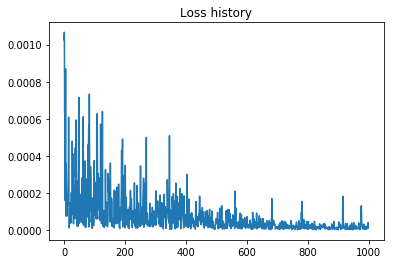

In [20]:
plt.plot(loss_history)
plt.title('Loss history')
plt.show()

# 4. Prediction

First, I want to take a look at how good my RNN was able to adapt to the training series:

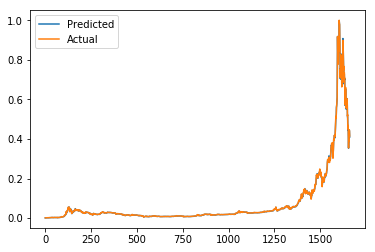

In [21]:
P_train = RNN.predict(X_backup)

plt.plot(P_train, label='Predicted')
plt.plot(Y_backup, label='Actual')
plt.legend()
plt.show()

The way the RNN adapted to train data is quite impressive. Let's now look if my model can generalize well:

In [22]:
# generate prediction
P_test = RNN.predict(X_test)

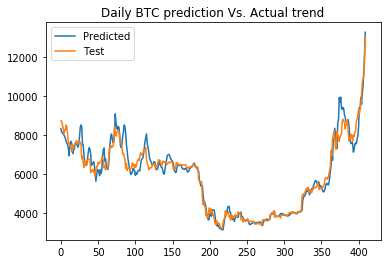

In [23]:
# reverse min-max scaling
P_test = P_test * (max_price - min_price) + min_price
Y_test = Y_test * (max_price - min_price) + min_price

# Visualize performance
plt.plot(P_test, label='Predicted')
plt.plot(Y_test, label='Test')
plt.legend()
plt.title('Daily BTC prediction Vs. Actual trend')
plt.show()

In [24]:
# RMSE
np.sqrt(np.mean((Y_test - P_test)**2))

442.65063

## Let's try a "longer" prediction

At this point, let's try to make predictions further in the future. I will feed each one-day forecast back into the model, and will make it predict a longer sequence:

[]

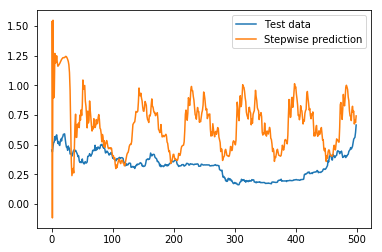

In [25]:
test_vector = list(price[len(Train)-window_size : len(Train)])

stepwise_prediction = []

for i in range(500):
    
    # reshape for RNN input
    np_test = np.array(test_vector)
    np_test = np_test.reshape((1, window_size, 1))
    
    # get daily BTC prediction
    current_prediction = RNN.predict(np_test)
    
    # append to vectors for next iteration
    stepwise_prediction.append(float(current_prediction))
    test_vector.append(float(current_prediction))
    test_vector = test_vector[1:]
    
    
plt.plot(Test, label = 'Test data')
plt.plot(stepwise_prediction, label = 'Stepwise prediction')
plt.legend()
plt.plot()

As you can see, performance is not good this time. It's a *many-to-one* task, i.e. a model that takes many values as input and returns *one* output value (a daily price prediction). A model that predicts BTC price just one day at a time is perhaps not the best tool around.

One this is worth noticing though: it seems the LSTM layers have learned some seasonality pattern of Training data. That is something that has probably emerged from the noise of the time series, suggesting that a glimps of pattern exists.

That's all for now. In future Notebooks, I will try two things: 
- multivariate models, that take multiple series as input (not just price itself but also other variables),
- *many-to-many* models, that I will train to predict sequences of events instead of sigle values.